# Predict DAX30 Stocks Prices

## Results

This is the last notebook from the capstone project for the Machine Learning Nanodegree from Udacity. 

In [1]:
# libraries needed for hyperparameter tunning.
import pandas as pd
import matplotlib.pyplot as plt

from utils.model_utils import run_arima_model, run_prophet_model, run_sequential_lstm_model, model_decision, cross_validation

from utils.data.data_config import LIST_DAX_COMPANIES
from utils.data_preprocessing import download_stocks_from_list, prepare_df, impute_data_points 


import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


### Best Imputation Method

Two imputation methods will be applied `linear` and `quadratic`. To evaluate which one perform better, we will evaluate it in the best ARIMA model after it has been tuned. Check `hyperparameter_tunning.ipynb` to see the development and the results. The best parameters have been already coded as default in the `models_class.py` or `models_utils.py`. 

In [2]:
df_clean_linear = prepare_df()
df_clean_quadratic = prepare_df()

df_imputed_linear = impute_data_points(df_clean_linear, interpolation_method='linear')
df_imputed_quadratic = impute_data_points(df_clean_quadratic, interpolation_method='quadratic')

In [3]:
baseline_rmse_linear, baseline_rmse_quadratic = {}, {}

for symbol in LIST_DAX_COMPANIES:
    baseline_rmse_linear[symbol] = cross_validation(df_imputed_linear, symbol, 'ARIMA')
    baseline_rmse_quadratic[symbol] = cross_validation(df_imputed_quadratic, symbol, 'ARIMA')
    print('')

-> ARIMA: The average RMSE of symbol 1COV.DE of the CV with 8-fold is: 1.085458783835686
-> ARIMA: The average RMSE of symbol 1COV.DE of the CV with 8-fold is: 1.0857296983260718

-> ARIMA: The average RMSE of symbol ADS.DE of the CV with 8-fold is: 4.560390905193605
-> ARIMA: The average RMSE of symbol ADS.DE of the CV with 8-fold is: 4.600804539208975

-> ARIMA: The average RMSE of symbol ALV.DE of the CV with 8-fold is: 2.652316076596226
-> ARIMA: The average RMSE of symbol ALV.DE of the CV with 8-fold is: 2.6419300712149183

-> ARIMA: The average RMSE of symbol BAS.DE of the CV with 8-fold is: 1.0078767396076298
-> ARIMA: The average RMSE of symbol BAS.DE of the CV with 8-fold is: 1.0302013087492694

-> ARIMA: The average RMSE of symbol BAYN.DE of the CV with 8-fold is: 1.2842236600624022
-> ARIMA: The average RMSE of symbol BAYN.DE of the CV with 8-fold is: 1.2826418001528892

-> ARIMA: The average RMSE of symbol BEI.DE of the CV with 8-fold is: 0.936660558624436
-> ARIMA: The ave

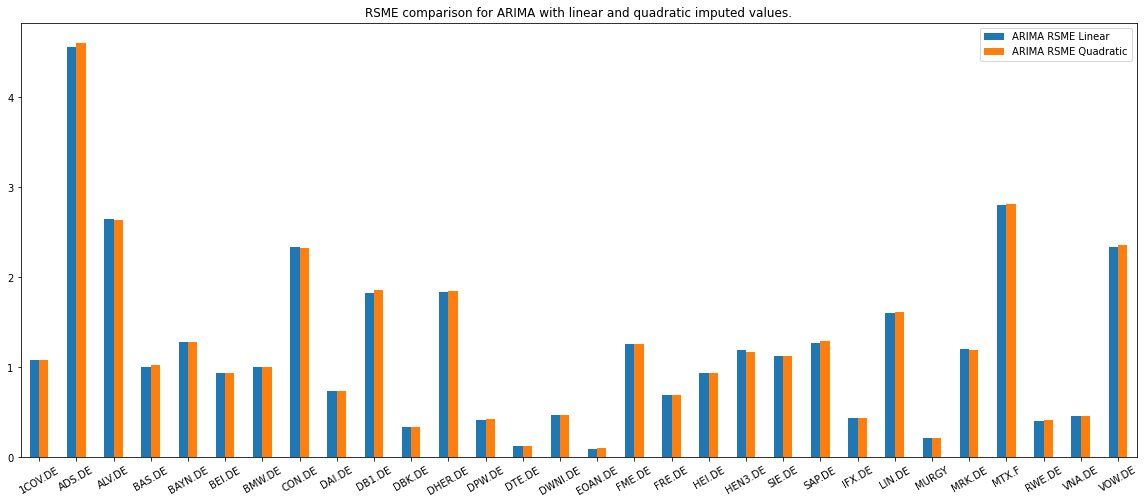

In [4]:
arima_linear = pd.DataFrame.from_dict(baseline_rmse_linear, orient='index',columns=['ARIMA RMSE Linear'])
arima_quadratic = pd.DataFrame.from_dict(baseline_rmse_quadratic, orient='index',columns=['ARIMA RMSE Quadratic'])

rmse_results_imputation = arima_linear.join(arima_quadratic)
rmse_results_imputation.plot.bar(rot=30, figsize=(20,8), title="RMSE comparison for ARIMA with linear and quadratic imputed values.");

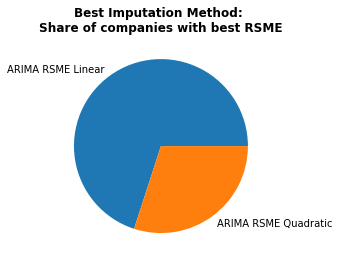

In [5]:
rmse_results_imputation['Best Method'] = rmse_results_imputation.T.idxmin()

rmse_results_imputation['Best Method'].value_counts().plot.pie()
plt.title("Best Imputation Method: \nShare of companies with best RMSE", fontweight='bold')
plt.ylabel("");

In [6]:
rmse_results_imputation['Differences'] = rmse_results_imputation['ARIMA RMSE Linear'] - rmse_results_imputation['ARIMA RMSE Quadratic']
rmse_results_imputation['Differences'].describe()

count    30.000000
mean     -0.004974
std       0.011687
min      -0.040414
25%      -0.007564
50%      -0.001450
75%       0.001307
max       0.018033
Name: Differences, dtype: float64

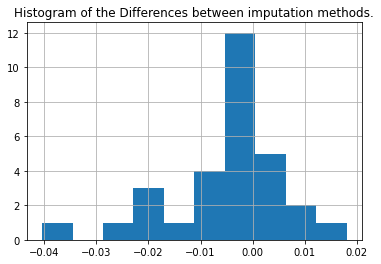

In [7]:
rmse_results_imputation['Differences'].hist()
plt.title("Histogram of the Differences between imputation methods.");

The best imputation method is the LINEAR. In the distribution we observe that it's centered in a negative value and the left side is more spread than the right one (positive towards quadratic from the way of creating differences variable).

The variable `baseline_rmse_linear` holds the best RMSE for ARIMA model, this will be our benchmark to analyze the performance of the other 2 methods.

In [8]:
baseline_rmse_linear

{'1COV.DE': 1.085458783835686,
 'ADS.DE': 4.560390905193605,
 'ALV.DE': 2.652316076596226,
 'BAS.DE': 1.0078767396076298,
 'BAYN.DE': 1.2842236600624022,
 'BEI.DE': 0.936660558624436,
 'BMW.DE': 1.000699860693544,
 'CON.DE': 2.3326047882249994,
 'DAI.DE': 0.7358617151025884,
 'DB1.DE': 1.831492539933866,
 'DBK.DE': 0.34173145968824564,
 'DHER.DE': 1.841864292834546,
 'DPW.DE': 0.41412405346282516,
 'DTE.DE': 0.12943326151132636,
 'DWNI.DE': 0.475360853527402,
 'EOAN.DE': 0.09798171290555935,
 'FME.DE': 1.2599561877358685,
 'FRE.DE': 0.6971959341445242,
 'HEI.DE': 0.9381440473762657,
 'HEN3.DE': 1.1923567560603412,
 'SIE.DE': 1.1210091961110193,
 'SAP.DE': 1.2714148094702453,
 'IFX.DE': 0.4387555344074925,
 'LIN.DE': 1.6014838337903075,
 'MURGY': 0.2136033426003074,
 'MRK.DE': 1.200981085689698,
 'MTX.F': 2.8053724470355754,
 'RWE.DE': 0.4061111471682601,
 'VNA.DE': 0.4567273218222431,
 'VOW.DE': 2.3414508840186783}

## Models Comparison

In this part we are going to compare the models and find which one has the best RMSE for most of the companies in our target DAX 30. 

We will compare the best RMSE for all the companies under the best parameters tuned in `hyperparameter_tuning.ipynb`.

Order of computation:

1. Prophet
2. Bidirectional LSTM with 50 units, 80 epochs.

In [9]:
prophet_rmse = {}

for symbol in LIST_DAX_COMPANIES:
    prophet_rmse[symbol] = cross_validation(df_imputed_linear, symbol, 'Prophet')

-> Prophet: The average RMSE of symbol 1COV.DE of the CV with 8-fold is: 3.938092090363407
-> Prophet: The average RMSE of symbol ADS.DE of the CV with 8-fold is: 7.727691566891047
-> Prophet: The average RMSE of symbol ALV.DE of the CV with 8-fold is: 8.734051168206394
-> Prophet: The average RMSE of symbol BAS.DE of the CV with 8-fold is: 4.092839189861575
-> Prophet: The average RMSE of symbol BAYN.DE of the CV with 8-fold is: 3.023732024673734
-> Prophet: The average RMSE of symbol BEI.DE of the CV with 8-fold is: 2.771937492954026
-> Prophet: The average RMSE of symbol BMW.DE of the CV with 8-fold is: 4.646494717188365
-> Prophet: The average RMSE of symbol CON.DE of the CV with 8-fold is: 8.68252485634566


-> Prophet: The average RMSE of symbol DAI.DE of the CV with 8-fold is: 3.888546971823473
-> Prophet: The average RMSE of symbol DB1.DE of the CV with 8-fold is: 3.165140902803461
-> Prophet: The average RMSE of symbol DBK.DE of the CV with 8-fold is: 1.0340491602045325
-> Prophet: The average RMSE of symbol DHER.DE of the CV with 8-fold is: 3.649966902823443
-> Prophet: The average RMSE of symbol DPW.DE of the CV with 8-fold is: 1.4267470068892993
-> Prophet: The average RMSE of symbol DTE.DE of the CV with 8-fold is: 0.4361035616368441
-> Prophet: The average RMSE of symbol DWNI.DE of the CV with 8-fold is: 1.5519569701444043
-> Prophet: The average RMSE of symbol EOAN.DE of the CV with 8-fold is: 0.26059500935840985
-> Prophet: The average RMSE of symbol FME.DE of the CV with 8-fold is: 2.8058688308755597
-> Prophet: The average RMSE of symbol FRE.DE of the CV with 8-fold is: 2.0703176529273364
-> Prophet: The average RMSE of symbol HEI.DE of the CV with 8-fold is: 4.006044937672567

In [10]:
bi_lstm_rmse = {}

for symbol in LIST_DAX_COMPANIES:
    bi_lstm_rmse[symbol] = cross_validation(df_imputed_linear, symbol, model_type='LSTM_BI')

-> LSTM_BI: The average RMSE of symbol 1COV.DE of the CV with 8-fold is: 2.1394515104699416
-> LSTM_BI: The average RMSE of symbol ADS.DE of the CV with 8-fold is: 6.311301810208507
-> LSTM_BI: The average RMSE of symbol ALV.DE of the CV with 8-fold is: 5.3958044538377345
-> LSTM_BI: The average RMSE of symbol BAS.DE of the CV with 8-fold is: 1.3267932560879763
-> LSTM_BI: The average RMSE of symbol BAYN.DE of the CV with 8-fold is: 1.7902685333922221
-> LSTM_BI: The average RMSE of symbol BEI.DE of the CV with 8-fold is: 2.0293861336353527
-> LSTM_BI: The average RMSE of symbol BMW.DE of the CV with 8-fold is: 1.24870509048869
-> LSTM_BI: The average RMSE of symbol CON.DE of the CV with 8-fold is: 3.6686255687482463
-> LSTM_BI: The average RMSE of symbol DAI.DE of the CV with 8-fold is: 1.0787833014266244
-> LSTM_BI: The average RMSE of symbol DB1.DE of the CV with 8-fold is: 2.3385277467453824
-> LSTM_BI: The average RMSE of symbol DBK.DE of the CV with 8-fold is: 0.39899008759317695

<AxesSubplot:title={'center':'RSME comparison for ARIMA, Prophet and LSTM models'}>

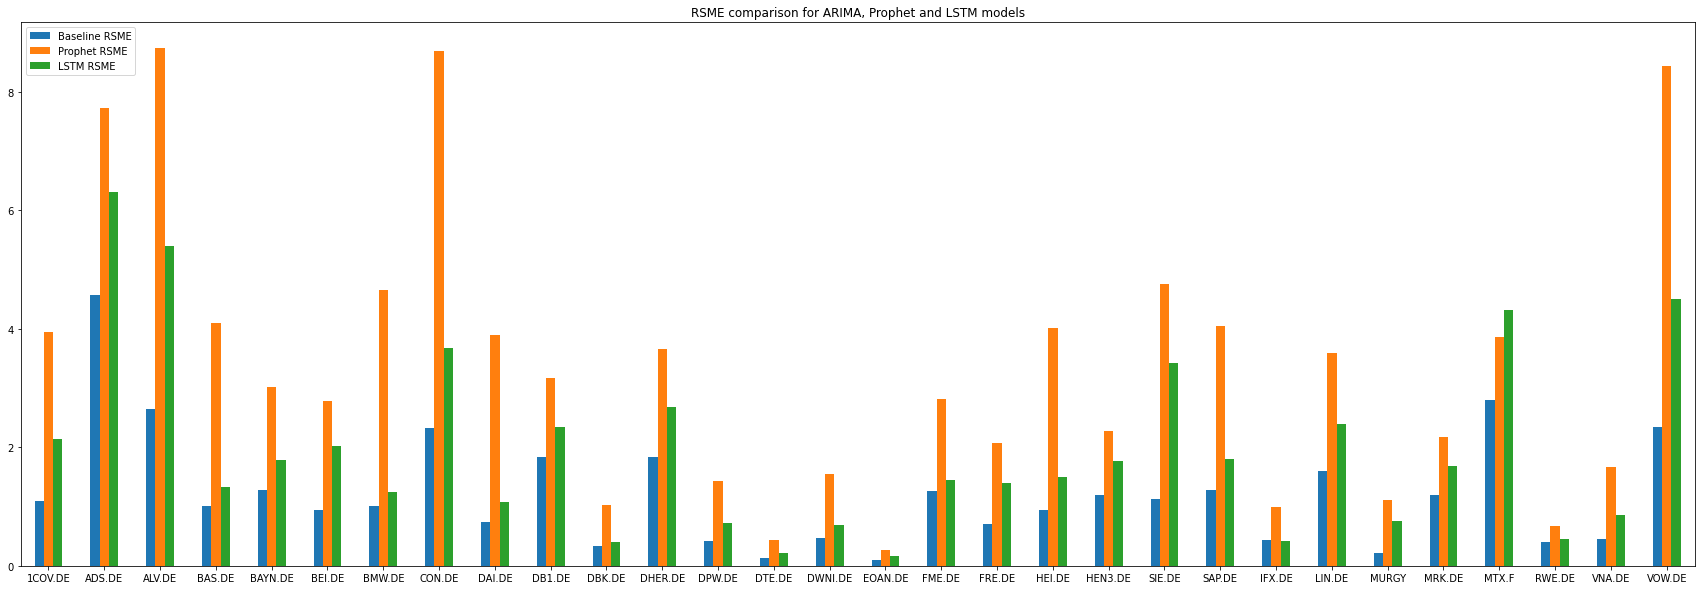

In [11]:
arima = pd.DataFrame.from_dict(baseline_rmse_linear, orient='index',columns=['Baseline RMSE'])
fb = pd.DataFrame.from_dict(prophet_rmse, orient='index',columns=['Prophet RMSE'])
lstm = pd.DataFrame.from_dict(bi_lstm_rmse, orient='index',columns=['LSTM RMSE'])

rmse_results = (arima.join(fb)).join(lstm) ## tochek
rmse_results.plot.bar(rot=0, figsize=(30,10), title="RMSE comparison for ARIMA, Prophet and LSTM models")

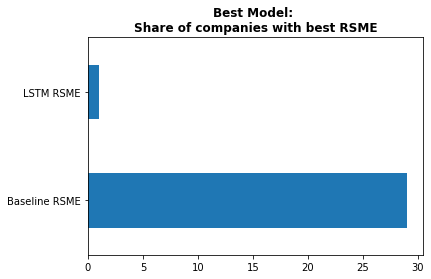

In [12]:
rmse_results['Best Method'] = rmse_results.T.idxmin()

rmse_results['Best Method'].T.value_counts().plot(kind='barh')
plt.title("Best Model: \nShare of companies with best RMSE", fontweight='bold')
plt.ylabel("");

## Next Best Action

Now that we have the best model chosen, we will compute the NEXT BEST ACTION. 

The conditions for the computation is:
    
- Choose the symbol.
- Do you have stocks invested in this company? YES / NO
    - If yes:
        - How many?
        - When did you buy them?
    - If no:
        - Use last 28 days computation
        - 100 stocks


**What we have to program is:**

1. Choose the symbol and download the data since 2016 until today.
2. Predict the next 5 days stock prices. 
3. Compute the possible gain in the next 5 days
4. Show the tendency forecast.
5. Compute the current position since the day they got the stock
6. Describe position variable
7. Decision based on investment
8. Decision based on company performance

In [13]:
# step 1.1 get the symbol
symbol = 'DHER.DE'

# step 1.2 get the data for the symbol
import yfinance as yf
import datetime
dt = datetime.datetime.today()

symbol_df = yf.download(symbol, start="2016-01-01", end=dt)

# step 1.3 impute the data for weekends
symbol_df = symbol_df.asfreq('D')
symbol_df_imp = impute_data_points(symbol_df)

[*********************100%***********************]  1 of 1 completed


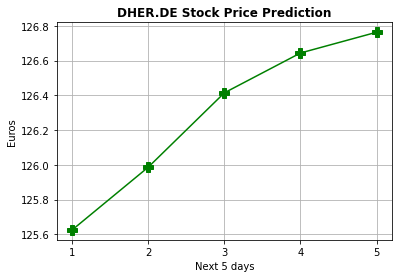

In [14]:
from models_class import ARIMAModel

# step 2 predict the next 5 days
arima_model = ARIMAModel(6, 1 ,0, 5) # p, d, q, prediction horizon
arima_model.prepare_data_train(symbol_df_imp, 'Adj Close')
arima_model.fit_predict()
arima_model.predictions

plt.plot(arima_model.predictions, color = 'green',marker="P", markersize=10)
plt.title(f'{symbol} Stock Price Prediction', fontweight='bold')
plt.xlabel('Next 5 days')
plt.xticks([0,1,2,3,4], [1,2,3,4,5])
plt.ylabel('Euros')
plt.grid()
plt.show()

In [15]:
gain_forecast = round(arima_model.predictions[4]-arima_model.predictions[0], 2)
print(f"Possible maximum increase in the next 5 days: {gain_forecast} Euros.")

Possible maximum increase in the next 5 days: 1.14 Euros.


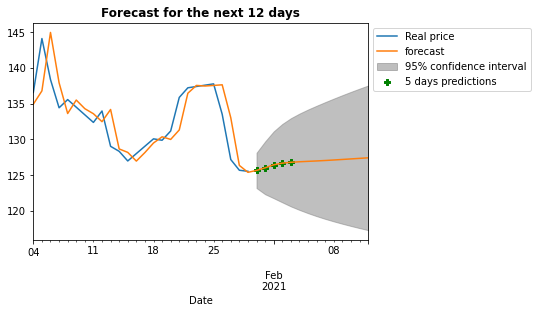

In [16]:
## Step 4, show the tendency in longer time

days_forecast = 12
start_date = '2021-01-04' # set to the beginning last month

fig, ax = plt.subplots()
symbol_df_imp.rename(columns={'Adj Close': 'Real price'})['Real price'].loc[start_date:].plot(ax=ax)
fig = arima_model.model.plot_predict(start_date, dt + datetime.timedelta(days=days_forecast), ax=ax, plot_insample=False)
plt.scatter([dt + datetime.timedelta(days=i) for i in range(5)], arima_model.predictions, color = 'green',marker="P", label='5 days predictions')
plt.legend(bbox_to_anchor=(1.50, 1))
plt.title(f"Forecast for the next {days_forecast} days", fontweight='bold')
plt.savefig(f'forecast_for_next_12_days.png')
plt.show();

In [17]:
# Step 5 compute the current position since the day they bought the stocks
symbol_df_imp['Returns'] = symbol_df_imp['Adj Close'] / symbol_df_imp['Adj Close'].shift(1) ## return for all the sample

own_shares = True
days_to_decide = 14

if own_shares:
    # parameters from user
    number_of_stocks = 50
    date_stock_acquisition = '2020-11-01'
else:
    # if the user hasn't invested then we will use fake parameters.
    number_of_stocks = 1
    date_stock_acquisition = dt - datetime.timedelta(days=days_to_decide)


df_since_stocks_acq = symbol_df_imp.loc[date_stock_acquisition:]
df_since_stocks_acq['Norm return'] = df_since_stocks_acq['Adj Close'] / df_since_stocks_acq.iloc[0]['Adj Close']
df_since_stocks_acq['Position'] = df_since_stocks_acq['Norm return'] * number_of_stocks
df_since_stocks_acq['Daily Return'] = df_since_stocks_acq['Position'].pct_change() # default is 1

In [18]:
import numpy as np

def sharpe_ratio(returns, rf, days=days_to_decide):
    """ Compute the sharpe ratio 
    params: returns: returns from the investment
    params: risk-free rate(rf)
    return sharpe ratio
    """
    sharpe_ratio = np.sqrt(days) * (returns.mean() - rf) / returns.std()
    return sharpe_ratio 

sharpe_ratio(df_since_stocks_acq['Daily Return'] , 0, days=days_to_decide)

0.4928082266212706

This is the sharpe ratio for the time period analyzed. In this case, time to decide is 14 days, so sharpe ratio only refers to the returns of the last 2 weeks.

### Decision


We will assume we have a **moderate strategy**, it will mean that we are able to have a bigger margin for benefits than for loses. We will stop the inversion if the forecast says we will lose more than 10% of what we have invested in that symbol and we won't sell until we made at least 30% of the inversion.
 

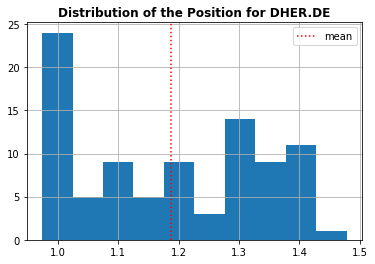

In [19]:
position_description = df_since_stocks_acq['Norm return'].describe()
df_since_stocks_acq['Norm return'].hist()
plt.title(f'Distribution of the Position for {symbol}', fontweight='bold')
plt.axvline(position_description['mean'], color='red', label='mean', ls=':')
plt.legend();

In [20]:
investment = df_since_stocks_acq['Adj Close'][0] * number_of_stocks
game_range = [investment - investment*0.1, investment + investment*0.3]
forecast = df_since_stocks_acq['Adj Close'][0] * df_since_stocks_acq['Position'][-1] + (gain_forecast * number_of_stocks)

In [21]:
def decision_best_next_action(forecast, game_range, position_description):
    print("\033[1mRegarding your investment... \033[0m")
    if forecast < game_range[0]:
        print(f"++ Sell now or you will lose more than 10% of your inversion.")
    elif forecast > game_range[1]:
        print(f"- Sell now to gain more than 20% of your investment!")
    else:
        print(f"+ Hold On, game is still on.")
        
    print("\033[1m \nRegarding the company... \033[0m") 
    if position_description['mean'] >= 1.15:
        print("++ Usually this company wins, invest more!")
    elif 1.01 < position_description['mean'] < 1.15:
        print("+ This company is promising! Invest if you haven't!")
    elif position_description['mean'] < 0.95:
        print("- Usually this company performs low.")
    else:
        print("- This company don't have enough volatility.")

In [22]:
decision_best_next_action(forecast, game_range, position_description)

Regarding your investment... 
+ Hold On, game is still on.
 
Regarding the company... 
++ Usually this company wins, invest more!


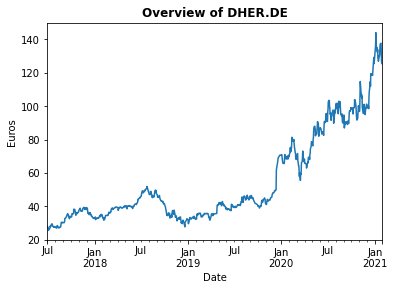

In [23]:
symbol_df_imp['Adj Close'].plot()
plt.title(f"Overview of {symbol}", fontweight='bold')
plt.ylabel('Euros');